$dv_i/dt = - \sum_{j \neq i} G M_j / r^3_{ij} (\bf{r}_i - \bf{r}_j)$ where $r_{ij} = |\bf{r}_i - \bf{r}_j| = [(x_i - x_j)^2 + (y_i - y_j)^2]^{1/2}$  <br>
$\bf{r}'_i = \bf{r}_i + \bf{v}_i \Delta t$ <br>
$\bf{v}'_i = \bf{v}_i + d\bf{v}_i/dt \Delta t$ <br>

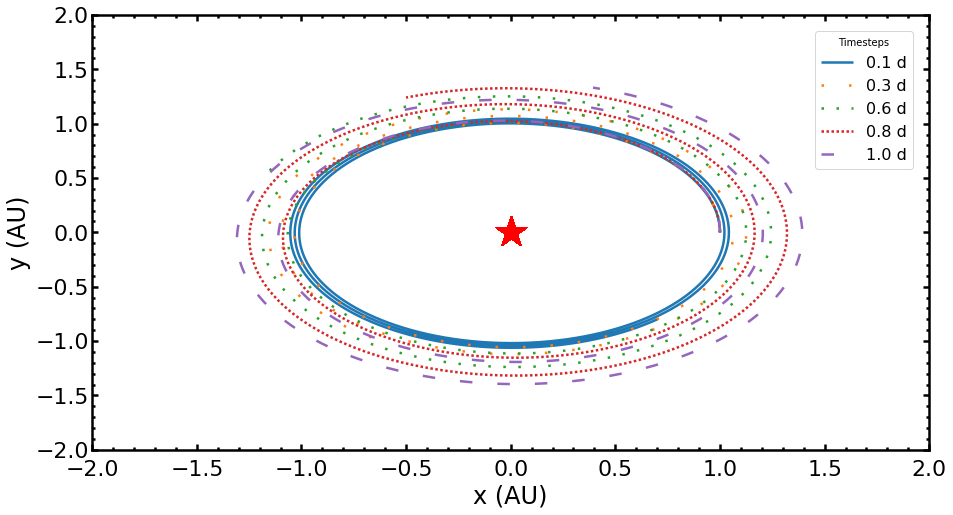

In [10]:
import matplotlib.pyplot as plt
from itertools import cycle
plt.style.use('./accretion.mplstyle')
import numpy as np
from astropy import constants as const
from astropy import units as u

linecycler = cycle([(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]) # densely dashdotdotted

delta_ts = [0.1,0.3,0.6,0.8,1]*u.day

G = const.G.cgs
a = const.au.to(u.cm)
m_e = const.M_earth.to(u.g)
m_s = const.M_sun.to(u.g)

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    x_j=r_j[0]
    y_j=r_j[1]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2)
    return r_ij

def KE(mass,v_x_i,v_y_i):
    v_r = np.sqrt(v_x_i**2+v_y_i**2)
    return 0.5*mass*(v_r**2)

def PE(m1,m2,r_ij):
    G = const.G.cgs
    return -G*m1*m2/r_ij

delta_KEs=[]
delta_Es=[]
delta_Ls=[]
delta_fLs=[]
t_ranges=[]

for delta_t in delta_ts:
    t_range = np.arange(0,3*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t
    steps=len(t_range)                                  # The number of steps in the time array
    # Set initial position for Earth and Sun
    x_i = [a]
    y_i = [0*u.cm]
    x_j = [(-a*m_e/m_s).to(u.cm)]
    y_j = [0*u.cm]
    # Set initial velocities for Earth and Sun
    v_x_i = [0*u.cm/u.day]
    v_y_i = [np.sqrt(G*m_s/(a+x_j[0])).to(u.cm/u.day)]
    v_x_j = [0*u.cm/u.day]
    v_y_j = [-v_y_i[0]*m_e/m_s]
    # Initialize empty arrays for change in KE and L
    delta_KE = []
    delta_E = []
    delta_L = []
    delta_fL = []

    for t in range(steps): # indexing each timestep as t
        # Add the new position to each coordinate array: x_final = v*delta_t + x_initial
        x_i.append(v_x_i[t]*delta_t+x_i[t])
        y_i.append(v_y_i[t]*delta_t+y_i[t])
        x_j.append(v_x_j[t]*delta_t+x_j[t])
        y_j.append(v_y_j[t]*delta_t+y_j[t])
        # Get radius vector from x,y coordinates
        r_i = [x_i[t].value,y_i[t].value]*u.cm
        r_j = [x_j[t].value,y_j[t].value]*u.cm
        # Get radius magnitudes from x,y coordinates
        r_ij = np.sqrt((x_i[t]-x_j[t])**2+(y_i[t]-y_j[t])**2)
        r_ji = np.sqrt((x_j[t]-x_i[t])**2+(y_j[t]-y_i[t])**2)
        # Get the delta v
        dv_i_dt = -(G * m_s / r_ij**3 * (r_i - r_j)).to(u.cm/u.day**2)
        dv_j_dt = -(G * m_e / r_ji**3 * (r_j - r_i)).to(u.cm/u.day**2)
        # Add the new velocity to each velocity array: v_final = v_initial + dv/dt * delta_t
        v_x_i.append(v_x_i[t]+dv_i_dt[0]*delta_t)
        v_y_i.append(v_y_i[t]+dv_i_dt[1]*delta_t)
        v_x_j.append(v_x_j[t]+dv_j_dt[0]*delta_t)
        v_y_j.append(v_y_j[t]+dv_j_dt[1]*delta_t)
        # Track change in Kinetic Energy
        delta_KE.append((0.5*m_e*((v_x_i[-1]**2+v_y_i[-1]**2)-(v_x_i[t]**2+v_y_i[t]**2))).to(u.erg))
        initial_E = KE(m_e, v_x_i[t],v_y_i[t]).cgs + PE(m_s, m_e, np.sqrt((x_i[t]-x_j[t])**2+(y_i[t]-y_j[t])**2)).cgs
        final_E = KE(m_e, v_x_i[-1],v_y_i[-1]).cgs + PE(m_s, m_e, np.sqrt((x_i[-1]-x_j[-1])**2+(y_i[-1]-y_j[-1])**2)).cgs
        delta_E.append(final_E/initial_E - 1)
        # Track change in angular momentum
        delta_L.append((m_e*(r_i[0]*v_x_i[t]-r_i[1]*v_y_i[t])).cgs)
        initial_L = (m_e*(r_i[0]*v_y_i[t]-r_i[1]*v_x_i[t])).cgs
        final_L = (m_e*(x_i[-1]*v_y_i[-1]-y_i[-1]*v_x_i[-1])).cgs
        delta_fL.append(final_L/initial_L - 1)
    # Save the delta_KE, delta_L and timescale for future plotting.
    delta_KEs.append(delta_KE)
    delta_Es.append(delta_E)
    delta_Ls.append(delta_L)
    delta_fLs.append(delta_fL)
    t_ranges.append(t_range)
    # Plot the coordinates for the Earth and the Sun over time.
    x_i = [(x/a).value for x in x_i]
    y_i = [(y/a).value for y in y_i]
    x_j = [(x/a).value for x in x_j]
    y_j = [(y/a).value for y in y_j]
    line=next(linecycler)
    plt.plot(x_i,y_i,linestyle=line,label=f'{delta_t}')
plt.ylabel('y (AU)')
plt.xlabel('x (AU)')
plt.legend(title=f'Timesteps')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.scatter(x_j,y_j,marker="*",s=1000,color='red')#,label=f'Sun')
plt.show()

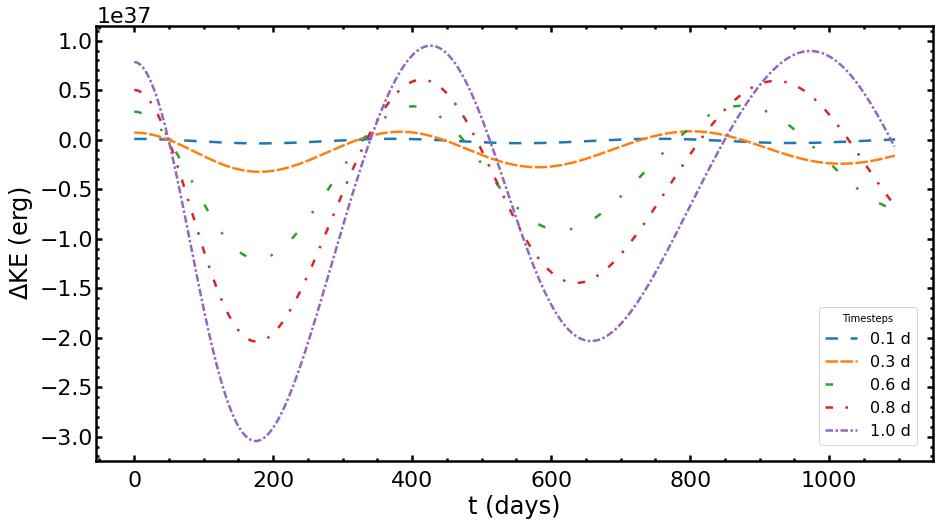

In [11]:

for i,delta_KE in enumerate(delta_KEs):
    t_range = t_ranges[i]
    t_range = [t.value for t in t_range]
    delta_KE = [k.value for k in delta_KE]
    line=next(linecycler)
    plt.plot(t_range,delta_KE,linestyle=line,label=f'{delta_ts[i]}')
plt.legend(title=f'Timesteps')
plt.xlabel('t (days)')
plt.ylabel(r'$\Delta$KE (erg)')
plt.show()

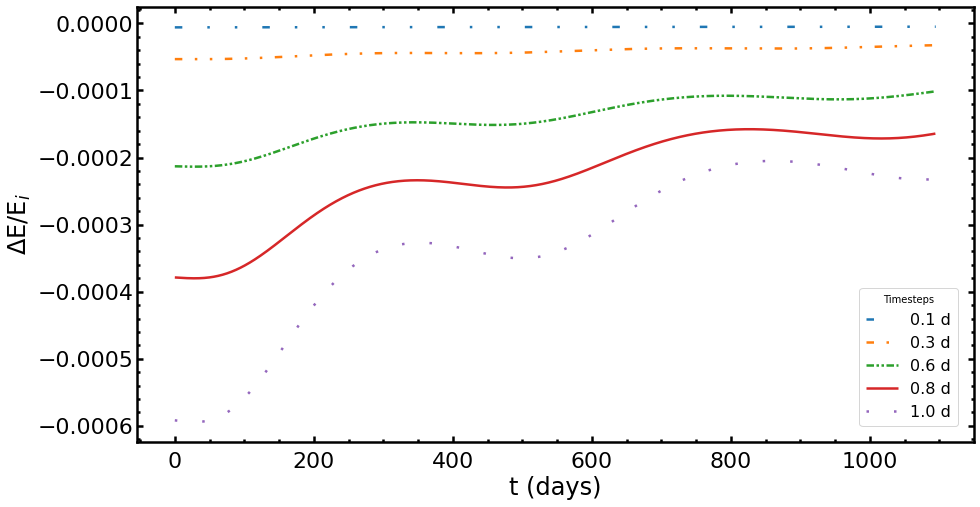

In [12]:
for i,delta_E in enumerate(delta_Es):
    t_range = t_ranges[i]
    t_range = [t.value for t in t_range]
    line=next(linecycler)
    plt.plot(t_range,delta_E,linestyle=line,label=f'{delta_ts[i]}')
plt.legend(title=f'Timesteps')
plt.xlabel('t (days)')
plt.ylabel(r'$\Delta$E/E$_i$')
plt.show()

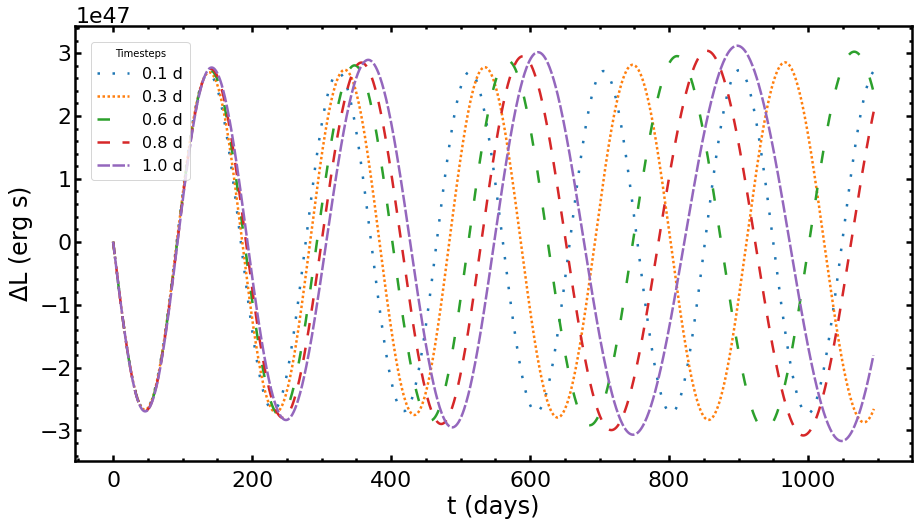

In [13]:

for i,delta_L in enumerate(delta_Ls):
    t_range = t_ranges[i]
    t_range = [t.value for t in t_range]
    delta_L = [l.value for l in delta_L]
    line=next(linecycler)
    plt.plot(t_range,delta_L,linestyle=line,label=f'{delta_ts[i]}')
plt.legend(title=f'Timesteps')
plt.xlabel('t (days)')
plt.ylabel(r'$\Delta$L (erg s)')
plt.show()

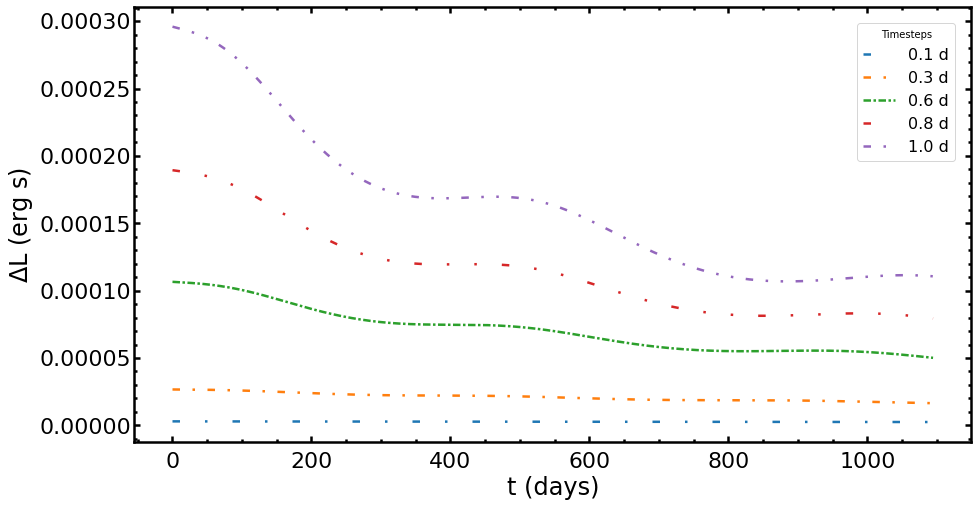

In [14]:
for i,delta_fL in enumerate(delta_fLs):
    t_range = t_ranges[i]
    t_range = [t.value for t in t_range]
    line=next(linecycler)
    plt.plot(t_range,delta_fL,linestyle=line,label=f'{delta_ts[i]}')
plt.legend(title=f'Timesteps')
plt.xlabel('t (days)')
plt.ylabel(r'$\Delta$L (erg s)')
plt.show()

In [15]:
np.shape(delta_fLs)

/storage/home/nxt5197/work/environments/tSETI/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(5,)